In [64]:
import os

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm
from cycler import cycler

from scipy.stats import norm

from astropy.io import fits

from coprofile import COGenerator

In [65]:
colors = mpl.cm.viridis(np.linspace(0., 1., 5))

axes_style = { 'grid'      : 'True',
               'labelsize' : '14',
               'labelpad'  : '8.0',
               'prop_cycle': cycler('color', colors) }
grid_style = { 'alpha'     : '0.75',
               'linestyle' : ':' }
font_style = { 'size'      : '14' }

mpl.rc('font', **font_style)
mpl.rc('axes', **axes_style)
mpl.rc('grid', **grid_style)

In [66]:
fmu_neg, fmu_fast = 0.066, 0.072

In [67]:
def plot_profiles(profiles, sample=True):
    if len(np.shape(np.array(profiles))) == 0:
        p = np.array([profiles])
    else:
        p = np.array(profiles)
    

    fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
    for i,profile in enumerate(p):
        ax.plot(profile.z, profile.CO, label='CO Profile {}'.format(i))
    if sample:
        z_samp, CO_samp, dCO_samp = p[0].sample_z()
        ax.errorbar(z_samp, CO_samp, yerr=dCO_samp, fmt='.')
    ax.set(xlim=(90,300),
            xlabel='depth [m]',
            ylim=(0,30),
            ylabel=r'$^{14}$CO concentration [molecule g$^{-1}$]')
    ax.legend(loc='lower right', fontsize=10)

In [68]:
generator = COGenerator('models/balco_14co_delta_neg_models.fits', 'models/balco_14co_delta_fast_models.fits')

In [69]:
const_profile = generator.generate()

In [70]:
slopes = np.arange(0., 0.6, 0.1)

t = generator.t
tmax = np.max(t)
tmin = np.min(t)


neg = fmu_neg * (1 + np.expand_dims(slopes, axis=1) * (t-tmax)/(tmax-tmin))
fast = fmu_fast * (1 + np.expand_dims(slopes, axis=1) * (t-tmax)/(tmax-tmin))

linear_profiles = []
for i in tqdm(range(len(slopes))):
    linear_profiles.append(generator.generate(neg[i], fast[i]))
    
linear_profiles = np.array(linear_profiles)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.11it/s]


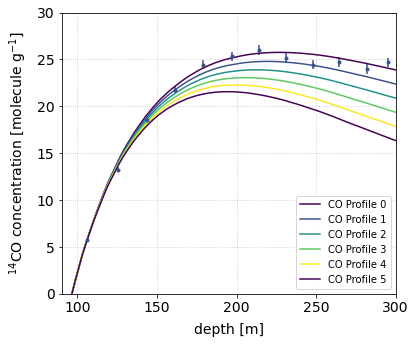

In [71]:
plot_profiles(linear_profiles)